<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.datamodel import Site, Observation
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 127.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 99.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1,

In [22]:
np.random.seed(786)
torch.manual_seed(786)


In [3]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "state_location":'hawaii',
        "lat":21.446911,
        "lon":-158.188736,
        "elevation":4.0,
        "fresh_data_time":'12',
        "reference_id":"c639b1f3-eb8f-11ed-802e-aec5a60999dc",
        "name":"Waianae, HI Substation",    },
    'or': {
        "state_location":'oregon',
        "lat":45.114559,
        "lon":-123.204903,
        "elevation":50.0,
        "fresh_data_time":'12',
        "reference_id":"5ebb4527-edbd-11ed-bf8d-128dcacebd72",
        "name":"Amity, OR Substation",
    },
    'tx': {
         "state_location":'texas',
        "lat":29.424122,
        "lon":-98.493629,
        "elevation":200.0,
        "fresh_data_time":'06',
        "reference_id":"8568f10f-eb8f-11ed-a556-128dcacebd72",
        "name":"San Antonio, TX Substation",

    },
    'ga': {
        "state_location":'georgia',
        "lat":31.044241,
        "lon":-84.879128,
        "elevation":0.0,
        "fresh_data_time":'06',
        "reference_id":"90c2a42c-f0ad-11ed-94b4-5edf5e2b3336",
        "name":"Donalsonville, GA Substation"
    },

}

tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df

def calculate_reference(start_time, end_time, location):
    def load_data(obs, start_date, end_date):
      return total_data[(total_data.time >= pd.to_datetime(start_date)) & (total_data.time <= pd.to_datetime(end_date))][['time','value']].set_index('time')

    name = states[location]['name']
    latitude = states[location]['lat']
    longitude = states[location]['lon']
    elevation = states[location]['elevation']
    timezone = states[location]['local_time_zone']
    site_id = states[location]['reference_id']
    site = Site(name = name, latitude = latitude, longitude = longitude, elevation = elevation,
                timezone = timezone, site_id = site_id)

    variable = 'net_load'
    interval_value_type = 'interval_mean'
    interval_length = pd.Timedelta(value = 1, unit = 'hour')
    interval_label = 'ending'
    site = site
    uncertainty = 0
    obs = Observation(name = name, variable = variable,
                      interval_value_type = interval_value_type,
                      interval_length = interval_length,
                      interval_label = interval_label,
                      site = site, uncertainty = uncertainty)

    observation  = obs
    forecast_start = pd.to_datetime(start_time + ' 00:00:00')
    forecast_end  = pd.to_datetime(end_time + ' 00:00:00')
    data_start  = forecast_start - pd.Timedelta(value = 30, unit = 'D')
    data_end = forecast_start #- pd.Timedelta(value = 1, unit = 'D')
    interval_length = interval_length
    interval_label = 'ending'
    load_data = load_data
    axis = 'x'
    constant_values = np.array([x for x in range(0,110,10)])


    baseline = persistence_probabilistic_timeofday(observation = obs,
                                        data_start = data_start,
                                        data_end = data_end,
                                        forecast_start = forecast_start,
                                        forecast_end = forecast_end,
                                        interval_length = interval_length,
                                        interval_label = interval_label,
                                        load_data = load_data,
                                        axis = 'y',
                                        constant_values = constant_values)
    baseline = pd.concat(baseline, axis = 1)
    baseline = baseline.reset_index().rename(columns = {'index':'time'}).rename(columns = {i:'p'+str(i*10) for i in range(11)})

    return baseline

In [73]:

state_location = 'hi'

training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/{}_historical.csv'.format(states[state_location]['state_location'])).drop(columns = 'quality_flag')
total_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/hawaii_2022-01-01-2023-06-28_total.csv'.format(states[state_location]['state_location']))
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/{}_2023-07-04_test.csv'.format(states[state_location]['state_location'])).drop(columns = 'quality_flag')


# test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/{}_2023-07-04_test.csv'.format(states[state_location]['state_location'])).drop(columns = 'quality_flag')
# test_data.time = pd.to_datetime(test_data.time)
# test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

# test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
# test_data['sunset'] = pd.to_datetime(test_data.sunset)

# test_data.sunrise = np.sin((test_data.sunrise.dt.hour + (test_data.sunrise.dt.minute / 60) - 12) / 24)
# test_data.sunset = np.sin((test_data.sunset.dt.hour + (test_data.sunset.dt.minute / 60) - 12) / 24)

# test_data['month'] = np.sin(test_data.time.dt.month / 12)


In [74]:
total_data.time = pd.to_datetime(total_data.time)

training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

training_data['hours'] = np.sin((training_data.time.dt.hour - 12) / 24)
test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = np.sin((training_data.sunrise.dt.hour + (training_data.sunrise.dt.minute / 60) - 12) / 24)
training_data.sunset = np.sin((training_data.sunset.dt.hour + (training_data.sunset.dt.minute / 60) - 12) / 24)




test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = np.sin((test_data.sunrise.dt.hour + (test_data.sunrise.dt.minute / 60) - 12) / 24)
test_data.sunset = np.sin((test_data.sunset.dt.hour + (test_data.sunset.dt.minute / 60) - 12) / 24)


training_data['month'] = np.sin(training_data.time.dt.month / 12)
test_data['month'] = np.sin(test_data.time.dt.month / 12)

train_data = training_data[(training_data.time <= '2023-03-13 00:00:00')]
val_data = training_data[(training_data.time >= '2023-03-22 00:00:00')
                        & (training_data.time <= '2023-05-31 00:00:00')]

In [75]:
test_data.shape

(863, 19)

In [76]:

class CDataset(Dataset):
    def __init__(self, data, lookback_start = 5, lookback_period = 10):

        old_cols = data.drop(columns = 'time').columns
        lookback_start = lookback_start
        lookback_dim = lookback_period
        lookback_end = lookback_dim + lookback_start - 1
        trend_features = len(old_cols) * lookback_dim
        for i in range(lookback_start, lookback_end + 1):
          new_cols = ['prev_{}'.format(i) + '_' + col for col in old_cols]
          data[new_cols] = None#
          data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
          data['prev_{}_dist'.format(i)] = None
          data.loc[:,'prev_{}_dist'.format(i)] = -1 * i


        data = data[data['prev_{}_value'.format(lookback_end)].isna() == False]
        data['std_hour'] = data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)
        old_cols = list(old_cols)
        old_cols.append('std_hour')

        X = data.drop(columns = ['time','value'])
        y = torch.tensor(data['value'].values)
        x1 = torch.tensor(X[[col for col in X.columns if col not in old_cols]].values.reshape((len(X), lookback_dim,-1)))
        x2 = torch.tensor(X[[col for col in X.columns if col in old_cols]].values.reshape((len(X),-1)))
        x2 = torch.concat([x2,torch.ones(x2.shape[0],x1.shape[-1] - x2.shape[-1])  * -1 * (x1.shape[-1] - x2.shape[-1])],dim = 1)
        X = torch.concat([x1,x2.view(x2.shape[0],1,x2.shape[1])], dim = 1)
        self.X = X
        self.y = y.view(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

In [77]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dim, num_heads = 3, output_dim = None):
      super(TransformerBlock, self).__init__()
      output_dim = embedding_dim if output_dim == None else output_dim

      self.multi_headed_attnetion = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                          num_heads=num_heads,
                                                          batch_first = True).to(float)


      self.query_layer = nn.Linear(embedding_dim,embedding_dim).to(float)
      self.key_layer = nn.Linear(embedding_dim,embedding_dim).to(float)
      self.value_layer = nn.Linear(embedding_dim,embedding_dim).to(float)

      self.layer_norm_1 = nn.LayerNorm(embedding_dim).to(float)

      self.relu = nn.ReLU().to(float)

      self.fc = nn.Linear(embedding_dim,output_dim).to(float)
      self.layer_norm_2 = nn.LayerNorm(output_dim).to(float)

  def forward(self, x):

    query = self.relu(self.query_layer(x))
    key = self.relu(self.key_layer(x))
    value = self.relu(self.value_layer(x))

    attn_output,_ = self.multi_headed_attnetion(query, key, value)

    attn_output = attn_output + x
    attn_output = self.layer_norm_1(attn_output)

    attn_output = self.layer_norm_2(self.relu(self.fc(attn_output)))

    return attn_output




In [78]:
class transformer_lite(nn.Module):
  def __init__(self):
    super(transformer_lite, self).__init__()
    self.multi_headed_attnetion = nn.MultiheadAttention(embed_dim=12,num_heads=1,batch_first = True).to(float)

    self.query_layer = nn.Linear(12,12).to(float)
    self.key_layer = nn.Linear(12,12).to(float)
    self.value_layer = nn.Linear(12,12).to(float)
    self.layer_norm_1 = nn.LayerNorm(12).to(float)
    self.relu = nn.ReLU().to(float)
    self.fc = nn.Linear(12,10).to(float)
    self.layer_norm_2 = nn.LayerNorm(10).to(float)
    self.final_layer1 = nn.Linear(10,7).to(float)
    self.final_layer2 = nn.Linear(7,7).to(float)
    self.final_layer3 = nn.Linear(7,5).to(float)
    self.final_layer4 = nn.Linear(5,1).to(float)
    self.transformer1 = TransformerBlock(15, 3, 12)
    self.transformer2 = TransformerBlock(12, 3, 12)
    self.transformer3 = TransformerBlock(12, 4, 12)
    self.embedding_layer_1 = nn.Linear(in_features = 19,
                                  out_features = 15).to(float)
    self.relu = nn.ReLU()
    self.embedding_layer_present1 = nn.Linear(in_features = 17,
                              out_features = 15).to(float)
    self.embedding_layer_present2 = nn.Linear(in_features = 15,
                              out_features = 12).to(float)

  def forward(self, x, using_loader = True):
    x_present = x[:,-1,:]
    seperator = x_present[:,-1][0].to(int)
    x_present = x_present[:,:seperator]
    x_past = x[:,:-1,:].to(float)

    std_hour = x_present[:,-1]
    x_present = x_present[:,:-1]


    x_present = self.embedding_layer_present1(x_present)
    x_present = self.relu(x_present)
    x_present = self.embedding_layer_present2(x_present)


    encoded_past = self.relu(self.embedding_layer_1(x_past))

    output = self.transformer1(encoded_past)
    output = self.transformer2(output)
    output = self.transformer3(output)


    query = self.relu(self.query_layer(x_present.view((x_present.shape[0], 1, x_present.shape[1]))))
    key = self.relu(self.key_layer(output))
    value = self.relu(self.value_layer(output))

    attn_output,_ = self.multi_headed_attnetion(query, key, value)

    attn_output = attn_output + x_present
    attn_output = self.layer_norm_1(attn_output)

    attn_output = self.layer_norm_2(self.relu(self.fc(attn_output)))

    x = torch.mean(attn_output, dim = 1)
    x = self.final_layer1(x)
    x = self.relu(x)
    x = self.final_layer2(x)
    x = self.relu(x)
    x = self.final_layer3(x)
    x = self.relu(x)
    x = self.final_layer4(x)

    vals = []
    for i in range(0, 11):
      q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
      pred2 = x + (1 * std_hour.view(-1,1)) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))
      vals.append(pred2)
    x = torch.concat(vals, dim = 1)#.view(-1)#.detach().numpy()

    return x





In [79]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()



In [80]:

batch_size = 64
train_dataset = CDataset(train_data, lookback_start=2, lookback_period=5)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(val_data, lookback_start=2, lookback_period=5)
val_loader = DataLoader(val_dataset, batch_size=batch_size)



<ipython-input-76-b9748da070d2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_cols] = None#
<ipython-input-76-b9748da070d2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_cols] = None#
<ipython-input-76-b9748da070d2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [81]:
model = transformer_lite()

In [82]:
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 100  # Specify the number of training epochs
train_losses = []
val_losses = []


for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

          outputs = model(batch_X)
          # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
          loss = crps_loss(outputs, batch_y)
          # loss = negLL(outputs, batch_y)
          val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
        loss = crps_loss(outputs, batch_y)
        # loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/len(train_loader))
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch [1/100], Train Loss: 0.1544584867215421, Val Loss: 0.2315113900950275
Epoch [2/100], Train Loss: 0.11070664492056778, Val Loss: 0.1558627885504211
Epoch [3/100], Train Loss: 0.15375637853685317, Val Loss: 0.12128664095770643
Epoch [4/100], Train Loss: 0.08935691829322996, Val Loss: 0.10185572354982256
Epoch [5/100], Train Loss: 0.0864571910948611, Val Loss: 0.10325310486639508
Epoch [6/100], Train Loss: 0.08895530324946208, Val Loss: 0.09314875126575636
Epoch [7/100], Train Loss: 0.0715238502848887, Val Loss: 0.09542847077307934
Epoch [8/100], Train Loss: 0.07077992888995249, Val Loss: 0.09434058377387021
Epoch [9/100], Train Loss: 0.09354637376439838, Val Loss: 0.0912375477712139
Epoch [10/100], Train Loss: 0.06739974312667414, Val Loss: 0.09084588814645025
Epoch [11/100], Train Loss: 0.12978609123468926, Val Loss: 0.09203065319669822
Epoch [12/100], Train Loss: 0.05807544185594142, Val Loss: 0.0896305824808
Epoch [13/100], Train Loss: 0.08166892062950384, Val Loss: 0.0888473435

In [20]:
batch_X.shape, batch_y.shape # bathch size, 5 day lookback ,  19 features?

(torch.Size([14, 6, 19]), torch.Size([14]))

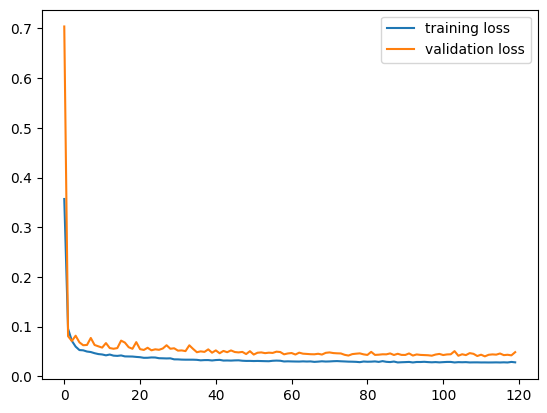

In [14]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

In [15]:
test_loader = DataLoader(CDataset(test_data))

<ipython-input-7-b9748da070d2>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-7-b9748da070d2>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-7-b9748da070d2>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique,

In [37]:
train_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_6_cloudcover_high,prev_6_shortwave_radiation,prev_6_direct_radiation,prev_6_diffuse_radiation,prev_6_direct_normal_irradiance,prev_6_sunset,prev_6_sunrise,prev_6_hours,prev_6_month,prev_6_dist
0,2022-01-01 01:00:00,0.420758,20.6,92,19.2,22.7,0.0,47,47,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6
1,2022-01-01 02:00:00,0.392404,21.1,93,19.9,23.5,0.0,63,62,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6
2,2022-01-01 03:00:00,0.379380,21.0,92,19.7,23.2,0.0,58,60,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6
3,2022-01-01 04:00:00,0.356155,20.7,92,19.4,22.7,0.0,65,72,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6
4,2022-01-01 05:00:00,0.339557,20.5,92,19.1,22.3,0.0,92,94,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10457,2023-03-12 20:00:00,0.555210,23.3,43,10.1,20.5,0.0,0,0,0,...,0.0,171.0,112.0,59.0,581.4,0.312061,-0.171372,0.287549,0.247404,-6
10458,2023-03-12 21:00:00,0.532215,21.5,50,10.6,18.7,0.0,6,0,5,...,0.0,17.0,7.0,10.0,152.9,0.312061,-0.171372,0.327195,0.247404,-6
10459,2023-03-12 22:00:00,0.482192,20.1,55,10.8,17.1,0.0,23,0,36,...,0.0,0.0,0.0,0.0,0.0,0.312061,-0.171372,0.366273,0.247404,-6
10460,2023-03-12 23:00:00,0.435166,18.7,59,10.5,15.5,0.0,8,0,6,...,0.0,0.0,0.0,0.0,0.0,0.312061,-0.171372,0.404715,0.247404,-6


In [92]:
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/{}_2023-07-04_test.csv'.format(states[state_location]['state_location'])).drop(columns = 'quality_flag')
test_data.time = pd.to_datetime(test_data.time)
test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = np.sin((test_data.sunrise.dt.hour + (test_data.sunrise.dt.minute / 60) - 12) / 24)
test_data.sunset = np.sin((test_data.sunset.dt.hour + (test_data.sunset.dt.minute / 60) - 12) / 24)

test_data['month'] = np.sin(test_data.time.dt.month / 12)


In [93]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours,month
0,2023-06-01 01:00:00,0.504681,24.1,81,20.6,26.7,0.0,33,33,0,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.442454,0.479426
1,2023-06-01 02:00:00,0.468936,23.8,81,20.4,26.4,0.0,13,13,0,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.404715,0.479426
2,2023-06-01 03:00:00,0.434043,23.7,81,20.2,26.2,0.0,25,23,4,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.366273,0.479426
3,2023-06-01 04:00:00,0.429787,23.6,81,20.1,26.1,0.0,30,26,4,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.327195,0.479426
4,2023-06-01 05:00:00,0.451064,23.6,81,20.2,26.2,0.0,37,37,0,0,0.0,0.0,0.0,0.0,0.294857,-0.254126,-0.287549,0.479426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,2023-07-06 19:00:00,NaN,26.5,67,19.8,27.6,0.0,3,3,0,0,100.0,56.0,44.0,317.7,0.300161,-0.250767,0.287549,0.550809
859,2023-07-06 20:00:00,NaN,25.5,70,19.6,26.8,0.0,24,24,0,0,3.0,1.0,2.0,15.6,0.300161,-0.250767,0.327195,0.550809
860,2023-07-06 21:00:00,NaN,25.0,71,19.3,26.5,0.0,32,32,0,0,0.0,0.0,0.0,0.0,0.300161,-0.250767,0.366273,0.550809
861,2023-07-06 22:00:00,NaN,24.7,73,19.5,26.3,0.0,46,46,0,0,0.0,0.0,0.0,0.0,0.300161,-0.250767,0.404715,0.550809


In [94]:
def test_data_mod(data, lookback_start, lookback_period):
      old_cols = data.drop(columns = 'time').columns
      lookback_start = lookback_start
      lookback_dim = lookback_period
      lookback_end = lookback_dim + lookback_start - 1
      trend_features = len(old_cols) * lookback_dim

      for i in range(lookback_start, lookback_end + 1):
        new_cols = ['prev_{}'.format(i) + '_' + col for col in old_cols]
        data[new_cols] = None#
        data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
        data['prev_{}_dist'.format(i)] = None
        data.loc[:,'prev_{}_dist'.format(i)] = -1 * i


      data = data[data['prev_{}_value'.format(lookback_end)].isna() == False]
      data['std_hour'] = data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)
      old_cols = list(old_cols)
      old_cols.append('std_hour')
      return data, old_cols



In [95]:
test_df, old_cols = test_data_mod(test_data.copy(), 2, 5)

<ipython-input-94-721ab18e263c>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-94-721ab18e263c>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-94-721ab18e263c>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

In [96]:
temp_df = test_df[test_data.value.isna() == False][:-9]

<ipython-input-96-229af3794168>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_df = test_df[test_data.value.isna() == False][:-9]


In [97]:
temp_df2 = temp_df[(temp_df.time >= '2023-06-25 01:00:00') & (temp_df.time <= '2023-06-26 00:00:00')]

In [98]:
# temp_df2 = temp_df[(temp_df.time >= start_date) & (temp_df.time <= end_date)]
X = temp_df2.drop(columns = ['time','value'])
y = torch.tensor(temp_df2['value'].values)
x1 = torch.tensor(X[[col for col in X.columns if col not in old_cols]].values.reshape((len(X), 5,-1)))
x2 = torch.tensor(X[[col for col in X.columns if col in old_cols]].values.reshape((len(X),-1)))
x2 = torch.concat([x2,torch.ones(x2.shape[0],x1.shape[-1] - x2.shape[-1])  * -1 * (x1.shape[-1] - x2.shape[-1])],dim = 1)
X = torch.concat([x1,x2.view(x2.shape[0],1,x2.shape[1])], dim = 1)

In [67]:
# """"""""
# #### for loop:

#   temp_df2 = temp_df[(temp_df.time >= start_date) & (temp_df.time <= end_date)]
#   X = temp_df2.drop(columns = ['time','value'])
#   y = torch.tensor(temp_df2['value'].values)
#   x1 = torch.tensor(X[[col for col in X.columns if col not in old_cols]].values.reshape((len(X), 5,-1)))
#   x2 = torch.tensor(X[[col for col in X.columns if col in old_cols]].values.reshape((len(X),-1)))
#   x2 = torch.concat([x2,torch.ones(x2.shape[0],x1.shape[-1] - x2.shape[-1])  * -1 * (x1.shape[-1] - x2.shape[-1])],dim = 1)
#   X = torch.concat([x1,x2.view(x2.shape[0],1,x2.shape[1])], dim = 1)
#   preds = model(X)


#   for i in range(0, 11):
#       # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

#       pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#       # vals.append(pred2)
#       plt.plot(pred2.detach().numpy(), label = str(i))

#   plt.plot(y, color = 'black', label = 'real')
#   plt.legend()
#   plt.show()


#   pred = preds.detach().numpy()
#   obs = y_test.detach().numpy()
#   fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
#   crps, crpss, _ = crps_and_crpss_scores(obs, pred, start_date, end_date, state_location)
#   print(crps, crpss)
#   daily_crps.append(crps)
#   daily_crpss.append(crpss)

In [99]:
preds = model(X)

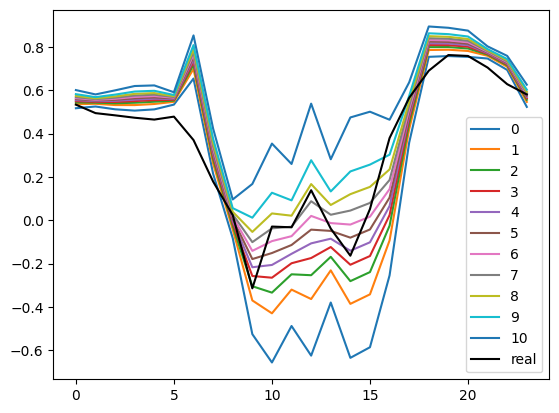

In [100]:
for i in range(0, 11):
    # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    # vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

plt.plot(y, color = 'black', label = 'real')
plt.legend()
plt.show()

<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


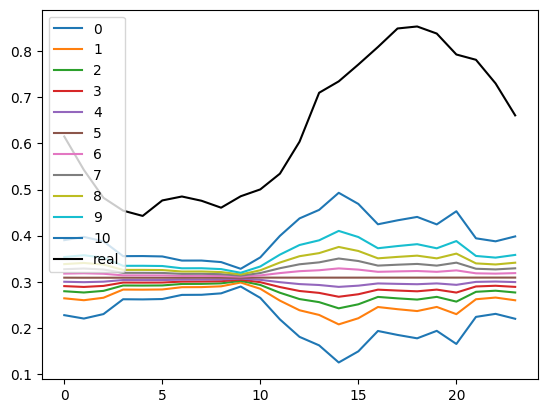

0.29755388739219696 -1.2108302246507145
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

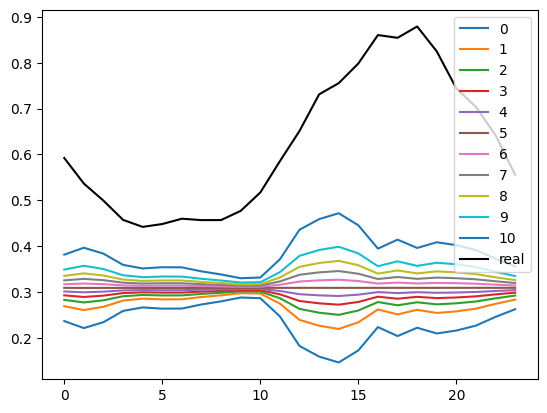

0.29407566107605493 -1.3669800571194952
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

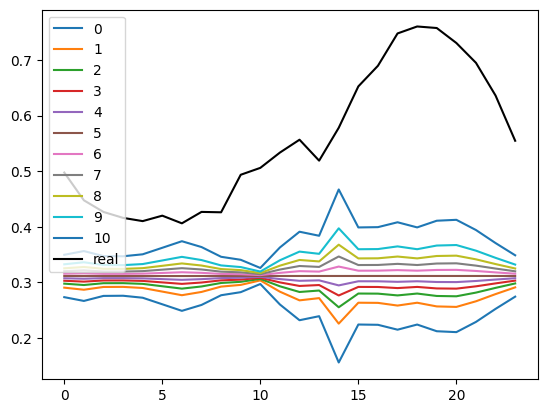

0.22631098124726015 -2.8229619587634622
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

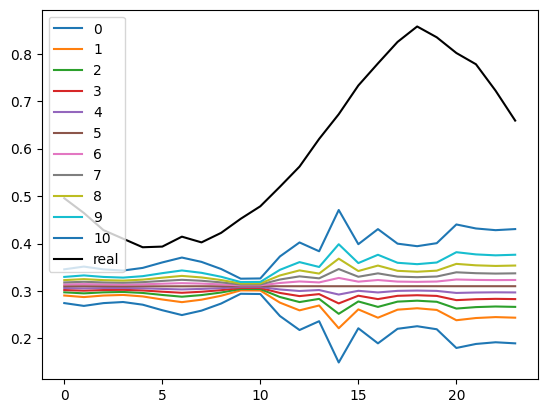

0.2603328552964648 -3.7632641384964245
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

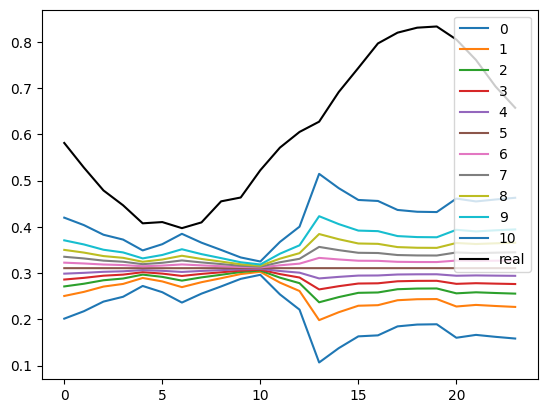

0.27102138883449617 -3.4318072494964715
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

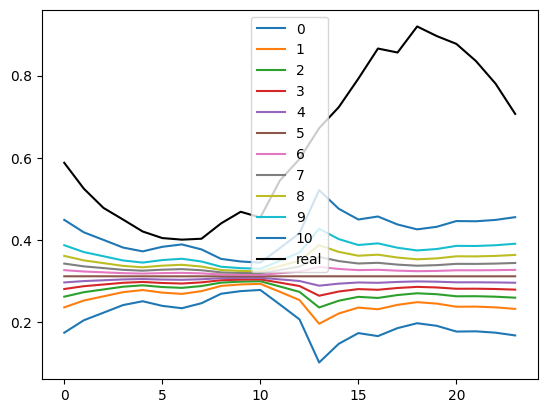

0.2924134912899217 -2.6046495157097813
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

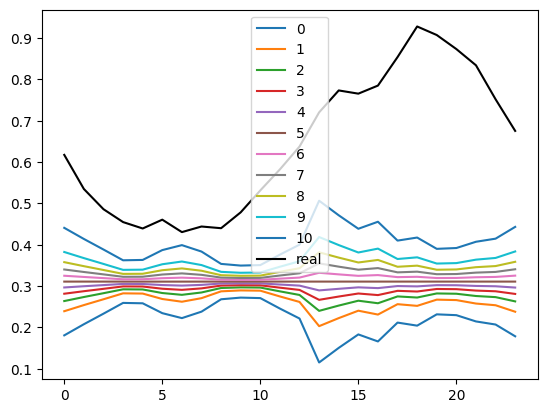

0.308262824595773 -2.3621915602970804
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

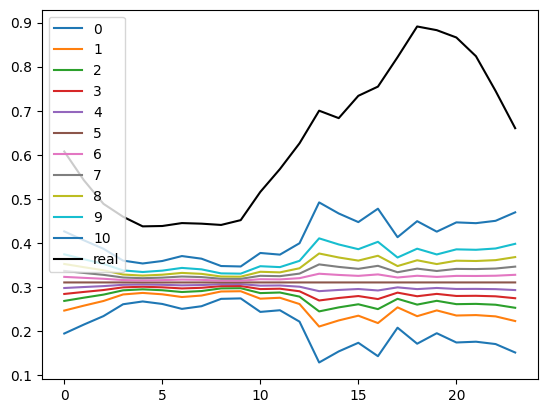

0.2910441815588163 -2.6903166091064623
data (24, 115)
torch.Size([24, 6, 19]) torch.Size([24])


<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_cols] = data.shift(i * 24)[old_cols].values
<ipython-input-43-da4751b010ac>:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_dist'.format(i)] = -1 * i
<ipython-input-43-da4751b010ac>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

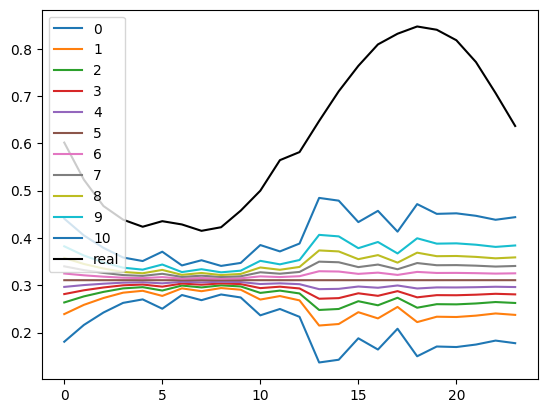

0.27554901159938444 -5.764114379265931


In [ ]:
daily_crps = []
daily_crpss = []



for day in range(21, 30):

  start_date = '2023-06-{:02d} 00:00:00'.format(day - 1)
  end_date = '2023-06-{:02d} 00:00:00'.format(day)

  X_test,y_test = test_data_mod(test_data.copy(deep=True),2,5, start_date + ' 01:00:00', end_date + ' 00:00:00')

  print(X_test.shape, y_test.shape)
  with torch.no_grad():
    model.eval()
    preds = model(X_test)

  hourly_deviations = []
  meanies = []
  # std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


  vals = []
  for i in range(0, 11):
    # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()


  pred = preds.detach().numpy()
  obs = y_test.detach().numpy()
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
  crps, crpss, _ = crps_and_crpss_scores(obs, pred, start_date, end_date, state_location)
  print(crps, crpss)
  daily_crps.append(crps)
  daily_crpss.append(crpss)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

In [ ]:
plt.scatter(range(len(daily_crps)), daily_crps)
plt.scatter(range(len(daily_crpss)), daily_crpss)
plt.axhline(0)
plt.show()